<a href="https://colab.research.google.com/github/Alamsyah-WM/Classification-DBP-Binding-vs-Non-Binding/blob/Minggu4/Minggu4_MLP%2BESMDBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score, confusion_matrix,
    classification_report, ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Define Model

In [ ]:
# BiLSTM Model (from Week 3)
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, x):
        # Reshape: (batch_size, input_dim) -> (batch_size, seq_len=1, input_dim)
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)  # (batch_size, 1, hidden_dim*2)
        x = self.dropout(lstm_out[:, -1, :])  # Take last output
        return self.fc(x)

# MLP Model (from Week 4)
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=1280, hidden_dims=[512, 256, 128, 64, 32],
                 dropout=0.3, output_dim=2):
        super().__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

print("✓ Model architectures defined!")

✓ Model architectures defined!


# Load dataset


In [ ]:
X_val_emb = np.load('/content/drive/MyDrive/esm_dbp_embeddings/X_val.npy')
y_val = np.load('/content/drive/MyDrive/esm_dbp_embeddings/y_val.npy')
X_test_emb = np.load('/content/drive/MyDrive/esm_dbp_embeddings/X_test.npy')
y_test = np.load('/content/drive/MyDrive/esm_dbp_embeddings/y_test.npy')

In [ ]:
X_train_esm1b = torch.load('/content/drive/MyDrive/esm_embed_2/DL/PDB/x_pdb_train.pt').numpy()
y_train_esm1b = np.load('/content/drive/MyDrive/esm_embed_2/DL/PDB/y_pdb_train.npy')
X_test_esm1b = torch.load('/content/drive/MyDrive/esm_embed_2/DL/PDB/x_pdb_test.pt').numpy()
y_test_esm1b = np.load('/content/drive/MyDrive/esm_embed_2/DL/PDB/y_pdb_test.npy')

# Recreate val split
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(
    X_train_esm1b, y_train_esm1b,
    test_size=186, stratify=y_train_esm1b, random_state=42
)

print(f"✓ ESM-DBP data: Val {X_val_emb.shape}, Test {X_test_emb.shape}")
print(f"✓ ESM-1b data: Val {X_val_lstm.shape}, Test {X_test_esm1b.shape}")

✓ ESM-DBP data: Val (186, 1280), Test (186, 1280)
✓ ESM-1b data: Val (186, 1280), Test (186, 1280)


# Load model

In [ ]:
checkpoint_lstm = torch.load('/content/bilstm_pdb.pt')
model_lstm = BiLSTMModel(
    input_dim=checkpoint_lstm['config']['input_dim'],
    hidden_dim=checkpoint_lstm['config']['hidden_dim'],
    dropout=checkpoint_lstm['config']['dropout'],
    output_dim=checkpoint_lstm['config']['output_dim']
).to(device)
model_lstm.load_state_dict(checkpoint_lstm['model_state_dict'])
model_lstm.eval()

# Load MLP model
checkpoint_mlp = torch.load('/content/ESM2_MLP.pt')
model_mlp = MLPClassifier(
    input_dim=checkpoint_mlp['config']['input_dim'],
    hidden_dims=checkpoint_mlp['config']['hidden_dims'],
    dropout=checkpoint_mlp['config']['dropout'],
    output_dim=checkpoint_mlp['config']['output_dim']
).to(device)
model_mlp.load_state_dict(checkpoint_mlp['model_state_dict'])
model_mlp.eval()

print("✓ Both models loaded!")

✓ Both models loaded!


# Define Ensemble

In [ ]:
def get_individual_predictions(model, X_data, device='cuda'):
    dataset = TensorDataset(torch.tensor(X_data, dtype=torch.float32))
    data_loader = DataLoader(dataset, batch_size=64, shuffle=False)

    all_probs = []
    all_preds = []

    model.eval()
    with torch.no_grad():
        for (X_batch,) in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_probs.extend(probs)
            all_preds.extend(preds)

    return np.array(all_preds), np.array(all_probs)


In [ ]:
def evaluate_model(y_true, y_pred, y_probs, model_name='Model'):
    """Evaluate model performance"""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f'\n{model_name} Results:')
    print(f'  Accuracy:    {acc:.4f}')
    print(f'  Precision:   {prec:.4f}')
    print(f'  Recall:      {rec:.4f}')
    print(f'  Specificity: {specificity:.4f}')
    print(f'  F1-score:    {f1:.4f}')
    print(f'  MCC:         {mcc:.4f}')
    print(f'  ROC-AUC:     {auc:.4f}')
    print(f'  Confusion Matrix:')
    print(f'    {cm}')

    return {
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1,
        'specificity': specificity, 'mcc': mcc, 'auc': auc
    }


In [ ]:
def comprehensive_evaluation(y_true, y_pred, y_probs, model_name='Model', show_plot=True):
    """
    Complete evaluation with all metrics, confusion matrix, and classification report
    """
    # Calculate all metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_probs)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = rec
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Print header
    print("\n" + "="*70)
    print(f"{model_name} - EVALUATION RESULTS".center(70))
    print("="*70)

    # Print metrics
    print(f"\n{'Metric':<20} {'Value':<15}")
    print("-"*35)
    print(f"{'Accuracy':<20} {acc:.4f}")
    print(f"{'Precision':<20} {prec:.4f}")
    print(f"{'Recall/Sensitivity':<20} {sensitivity:.4f}")
    print(f"{'Specificity':<20} {specificity:.4f}")
    print(f"{'F1-Score':<20} {f1:.4f}")
    print(f"{'MCC':<20} {mcc:.4f}")
    print(f"{'ROC-AUC':<20} {roc_auc:.4f}")

    # Print confusion matrix
    print(f"\n{'Confusion Matrix:'}")
    print(f"{'':>20} {'Predicted 0':<15} {'Predicted 1':<15}")
    print(f"{'Actual 0':<20} {tn:<15} {fp:<15}")
    print(f"{'Actual 1':<20} {fn:<15} {tp:<15}")

    # Classification Report
    print(f"\n{'Classification Report:'}")
    print(classification_report(y_true, y_pred, target_names=['Non-DBP', 'DBP'], digits=4))

    if show_plot:
        # Create figure with 2 subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Plot 1: Confusion Matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-DBP', 'DBP'])
        disp.plot(ax=axes[0], cmap='Blues', values_format='d')
        axes[0].set_title(f'{model_name}\nConfusion Matrix')

        # Plot 2: ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        roc_auc_val = auc(fpr, tpr)

        axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                    label=f'ROC curve (AUC = {roc_auc_val:.4f})')
        axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title(f'{model_name}\nROC Curve')
        axes[1].legend(loc="lower right")
        axes[1].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

    return {
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1,
        'sensitivity': sensitivity, 'specificity': specificity,
        'mcc': mcc, 'auc': roc_auc, 'confusion_matrix': cm
    }


In [ ]:
print("\n" + "="*60)
print("GETTING PREDICTIONS")
print("="*60)

# BiLSTM predictions (on ESM-1b embeddings)
lstm_preds_val, lstm_probs_val = get_individual_predictions(model_lstm, X_val_lstm, device)
lstm_preds_test, lstm_probs_test = get_individual_predictions(model_lstm, X_test_esm1b, device)

# MLP predictions (on ESM-DBP embeddings)
mlp_preds_val, mlp_probs_val = get_individual_predictions(model_mlp, X_val_emb, device)
mlp_preds_test, mlp_probs_test = get_individual_predictions(model_mlp, X_test_emb, device)

print("✓ Individual predictions obtained")


GETTING PREDICTIONS
✓ Individual predictions obtained


## Run ensemble

In [ ]:
# Validation ensemble
ensemble_probs_val = (0.5 * lstm_probs_val) + (0.5 * mlp_probs_val)
ensemble_preds_val = (ensemble_probs_val >= 0.5).astype(int)

# Test ensemble
ensemble_probs_test = (0.5 * lstm_probs_test) + (0.5 * mlp_probs_test)
ensemble_preds_test = (ensemble_probs_test >= 0.5).astype(int)

In [ ]:
print("\n" + "="*70)
print("FINDING OPTIMAL ENSEMBLE WEIGHTS (Validation Set)")
print("="*70)

weight_candidates = np.arange(0.0, 1.05, 0.05)
results = []

for w_lstm in weight_candidates:
    w_mlp = 1.0 - w_lstm
    ensemble_probs = (w_lstm * lstm_probs_val) + (w_mlp * mlp_probs_val)
    ensemble_preds = (ensemble_probs >= 0.5).astype(int)
    f1 = f1_score(y_val_lstm, ensemble_preds)

    results.append({'w_lstm': w_lstm, 'w_mlp': w_mlp, 'f1': f1})
    print(f"BiLSTM={w_lstm:.2f}, MLP={w_mlp:.2f} → Val F1={f1:.4f}")

results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['f1'].idxmax()]

print("\n" + "="*70)
print("OPTIMAL WEIGHTS FOUND")
print("="*70)
print(f"BiLSTM weight: {best_result['w_lstm']:.2f}")
print(f"MLP weight:    {best_result['w_mlp']:.2f}")
print(f"Val F1 score:  {best_result['f1']:.4f}")



FINDING OPTIMAL ENSEMBLE WEIGHTS (Validation Set)
BiLSTM=0.00, MLP=1.00 → Val F1=0.8523
BiLSTM=0.05, MLP=0.95 → Val F1=0.8523
BiLSTM=0.10, MLP=0.90 → Val F1=0.8523
BiLSTM=0.15, MLP=0.85 → Val F1=0.8523
BiLSTM=0.20, MLP=0.80 → Val F1=0.8636
BiLSTM=0.25, MLP=0.75 → Val F1=0.8686
BiLSTM=0.30, MLP=0.70 → Val F1=0.8736
BiLSTM=0.35, MLP=0.65 → Val F1=0.8800
BiLSTM=0.40, MLP=0.60 → Val F1=0.8966
BiLSTM=0.45, MLP=0.55 → Val F1=0.9029
BiLSTM=0.50, MLP=0.50 → Val F1=0.9704
BiLSTM=0.55, MLP=0.45 → Val F1=0.9880
BiLSTM=0.60, MLP=0.40 → Val F1=0.9880
BiLSTM=0.65, MLP=0.35 → Val F1=0.9880
BiLSTM=0.70, MLP=0.30 → Val F1=0.9939
BiLSTM=0.75, MLP=0.25 → Val F1=0.9939
BiLSTM=0.80, MLP=0.20 → Val F1=0.9939
BiLSTM=0.85, MLP=0.15 → Val F1=0.9939
BiLSTM=0.90, MLP=0.10 → Val F1=0.9939
BiLSTM=0.95, MLP=0.05 → Val F1=0.9939
BiLSTM=1.00, MLP=0.00 → Val F1=0.9939

OPTIMAL WEIGHTS FOUND
BiLSTM weight: 0.70
MLP weight:    0.30
Val F1 score:  0.9939



######################################################################
#                 VALIDATION SET - DETAILED RESULTS                  #
######################################################################

          BiLSTM (ESM-1b) - Validation - EVALUATION RESULTS           

Metric               Value          
-----------------------------------
Accuracy             0.9946
Precision            1.0000
Recall/Sensitivity   0.9880
Specificity          1.0000
F1-Score             0.9939
MCC                  0.9892
ROC-AUC              0.9996

Confusion Matrix:
                     Predicted 0     Predicted 1    
Actual 0             103             0              
Actual 1             1               82             

Classification Report:
              precision    recall  f1-score   support

     Non-DBP     0.9904    1.0000    0.9952       103
         DBP     1.0000    0.9880    0.9939        83

    accuracy                         0.9946       186
   macro avg     0.9952 

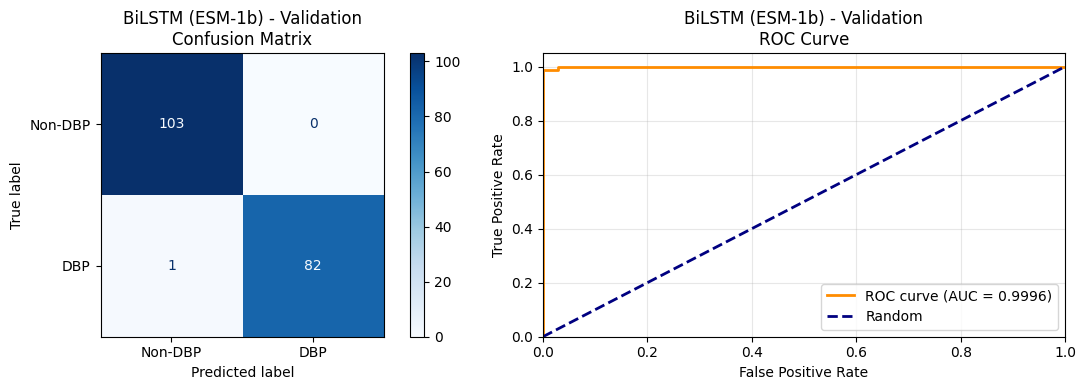


           MLP (ESM-DBP) - Validation - EVALUATION RESULTS            

Metric               Value          
-----------------------------------
Accuracy             0.8602
Precision            0.8065
Recall/Sensitivity   0.9036
Specificity          0.8252
F1-Score             0.8523
MCC                  0.7246
ROC-AUC              0.9373

Confusion Matrix:
                     Predicted 0     Predicted 1    
Actual 0             85              18             
Actual 1             8               75             

Classification Report:
              precision    recall  f1-score   support

     Non-DBP     0.9140    0.8252    0.8673       103
         DBP     0.8065    0.9036    0.8523        83

    accuracy                         0.8602       186
   macro avg     0.8602    0.8644    0.8598       186
weighted avg     0.8660    0.8602    0.8606       186



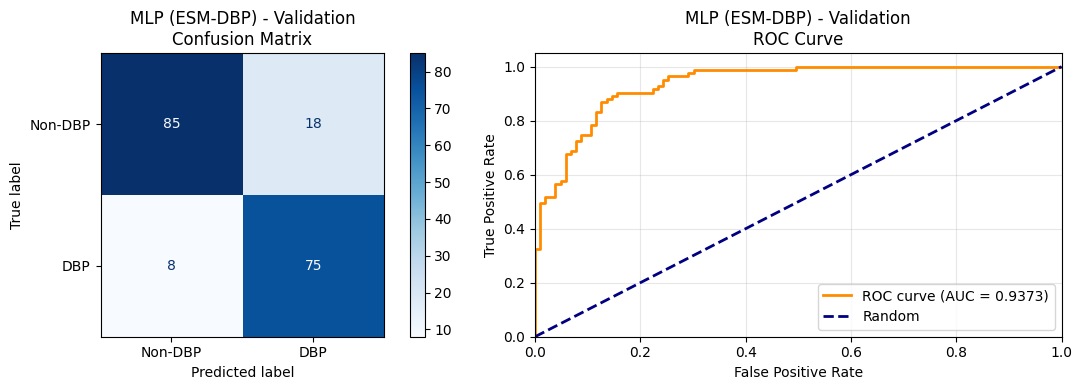


  Ensemble (BiLSTM=0.70, MLP=0.30) - Validation - EVALUATION RESULTS  

Metric               Value          
-----------------------------------
Accuracy             0.9946
Precision            1.0000
Recall/Sensitivity   0.9880
Specificity          1.0000
F1-Score             0.9939
MCC                  0.9892
ROC-AUC              0.9977

Confusion Matrix:
                     Predicted 0     Predicted 1    
Actual 0             103             0              
Actual 1             1               82             

Classification Report:
              precision    recall  f1-score   support

     Non-DBP     0.9904    1.0000    0.9952       103
         DBP     1.0000    0.9880    0.9939        83

    accuracy                         0.9946       186
   macro avg     0.9952    0.9940    0.9946       186
weighted avg     0.9947    0.9946    0.9946       186



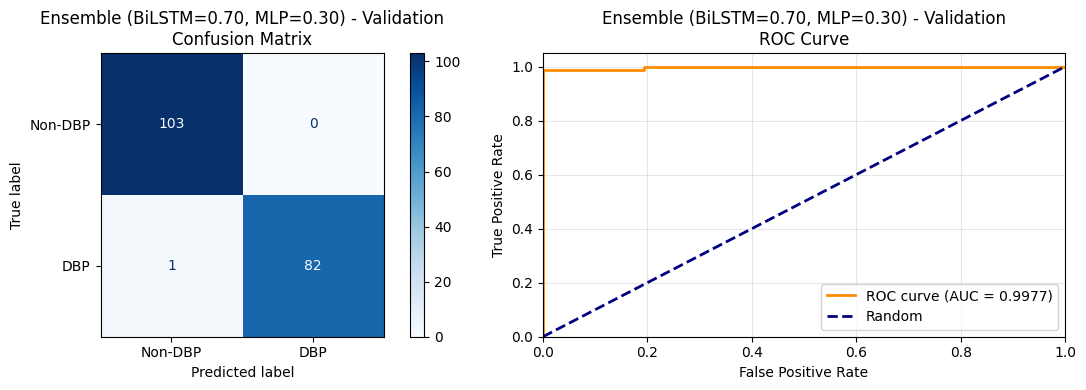

In [ ]:
print("\n" + "#"*70)
print("#" + " VALIDATION SET - DETAILED RESULTS ".center(68) + "#")
print("#"*70)

lstm_val_results = comprehensive_evaluation(
    y_val_lstm, lstm_preds_val, lstm_probs_val,
    'BiLSTM (ESM-1b) - Validation', show_plot=True
)

mlp_val_results = comprehensive_evaluation(
    y_val, mlp_preds_val, mlp_probs_val,
    'MLP (ESM-DBP) - Validation', show_plot=True
)

# Ensemble with optimal weights on validation
optimal_w_lstm = best_result['w_lstm']
optimal_w_mlp = best_result['w_mlp']
ensemble_probs_val_optimal = (optimal_w_lstm * lstm_probs_val) + (optimal_w_mlp * mlp_probs_val)
ensemble_preds_val_optimal = (ensemble_probs_val_optimal >= 0.5).astype(int)

ensemble_val_results = comprehensive_evaluation(
    y_val_lstm, ensemble_preds_val_optimal, ensemble_probs_val_optimal,
    f'Ensemble (BiLSTM={optimal_w_lstm:.2f}, MLP={optimal_w_mlp:.2f}) - Validation',
    show_plot=True
)



######################################################################
#                    TEST SET - DETAILED RESULTS                     #
######################################################################

             BiLSTM (ESM-1b) - Test - EVALUATION RESULTS              

Metric               Value          
-----------------------------------
Accuracy             0.8172
Precision            0.8391
Recall/Sensitivity   0.7849
Specificity          0.8495
F1-Score             0.8111
MCC                  0.6357
ROC-AUC              0.9106

Confusion Matrix:
                     Predicted 0     Predicted 1    
Actual 0             79              14             
Actual 1             20              73             

Classification Report:
              precision    recall  f1-score   support

     Non-DBP     0.7980    0.8495    0.8229        93
         DBP     0.8391    0.7849    0.8111        93

    accuracy                         0.8172       186
   macro avg     0.8185 

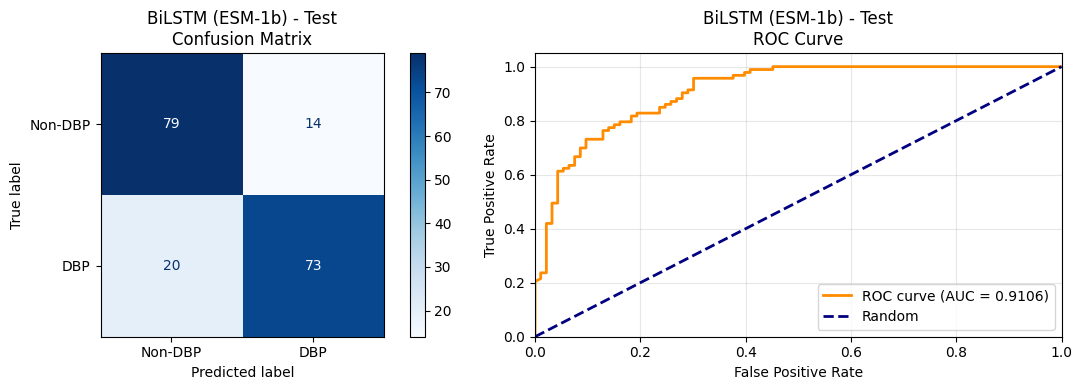


              MLP (ESM-DBP) - Test - EVALUATION RESULTS               

Metric               Value          
-----------------------------------
Accuracy             0.7849
Precision            0.7477
Recall/Sensitivity   0.8602
Specificity          0.7097
F1-Score             0.8000
MCC                  0.5765
ROC-AUC              0.8608

Confusion Matrix:
                     Predicted 0     Predicted 1    
Actual 0             66              27             
Actual 1             13              80             

Classification Report:
              precision    recall  f1-score   support

     Non-DBP     0.8354    0.7097    0.7674        93
         DBP     0.7477    0.8602    0.8000        93

    accuracy                         0.7849       186
   macro avg     0.7916    0.7849    0.7837       186
weighted avg     0.7916    0.7849    0.7837       186



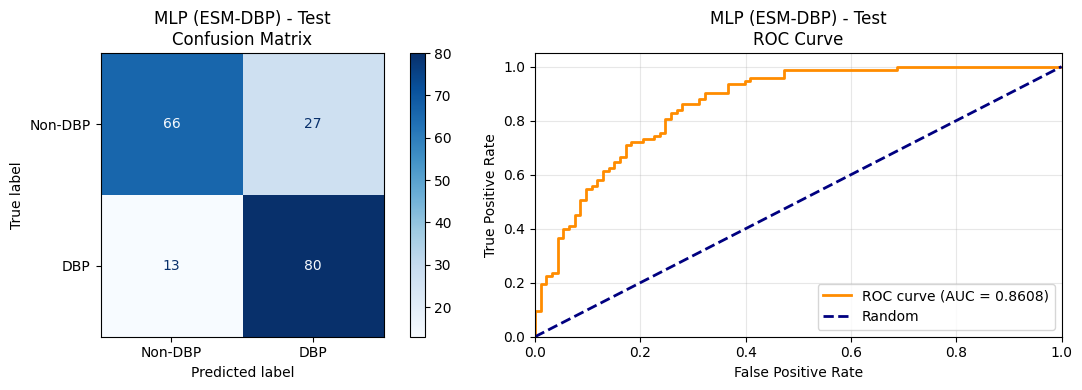


     Ensemble (BiLSTM=0.70, MLP=0.30) - Test - EVALUATION RESULTS     

Metric               Value          
-----------------------------------
Accuracy             0.8226
Precision            0.8409
Recall/Sensitivity   0.7957
Specificity          0.8495
F1-Score             0.8177
MCC                  0.6461
ROC-AUC              0.8991

Confusion Matrix:
                     Predicted 0     Predicted 1    
Actual 0             79              14             
Actual 1             19              74             

Classification Report:
              precision    recall  f1-score   support

     Non-DBP     0.8061    0.8495    0.8272        93
         DBP     0.8409    0.7957    0.8177        93

    accuracy                         0.8226       186
   macro avg     0.8235    0.8226    0.8225       186
weighted avg     0.8235    0.8226    0.8225       186



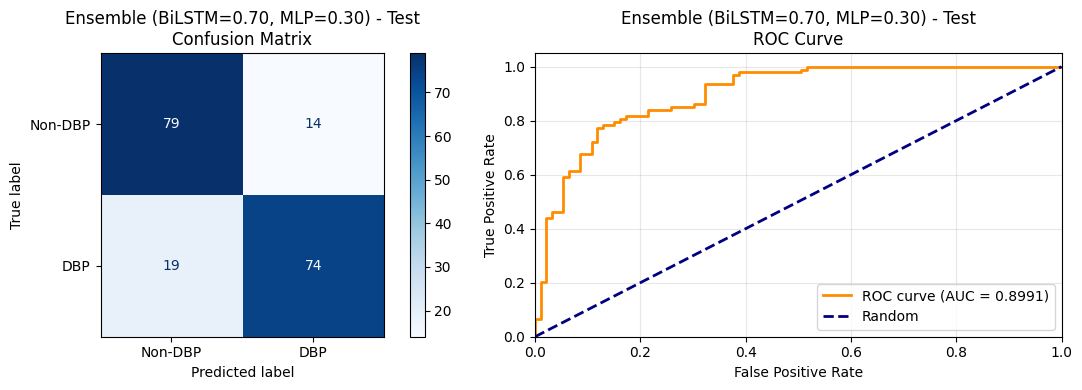

In [ ]:
print("\n" + "#"*70)
print("#" + " TEST SET - DETAILED RESULTS ".center(68) + "#")
print("#"*70)

# Apply optimal weights to test set
ensemble_probs_test_optimal = (optimal_w_lstm * lstm_probs_test) + (optimal_w_mlp * mlp_probs_test)
ensemble_preds_test_optimal = (ensemble_probs_test_optimal >= 0.5).astype(int)

lstm_test_results = comprehensive_evaluation(
    y_test_esm1b, lstm_preds_test, lstm_probs_test,
    'BiLSTM (ESM-1b) - Test', show_plot=True
)

mlp_test_results = comprehensive_evaluation(
    y_test, mlp_preds_test, mlp_probs_test,
    'MLP (ESM-DBP) - Test', show_plot=True
)

ensemble_test_results = comprehensive_evaluation(
    y_test_esm1b, ensemble_preds_test_optimal, ensemble_probs_test_optimal,
    f'Ensemble (BiLSTM={optimal_w_lstm:.2f}, MLP={optimal_w_mlp:.2f}) - Test',
    show_plot=True
)
